In [714]:
import numpy as np
import matplotlib.pyplot as plt
import math as ma
import time

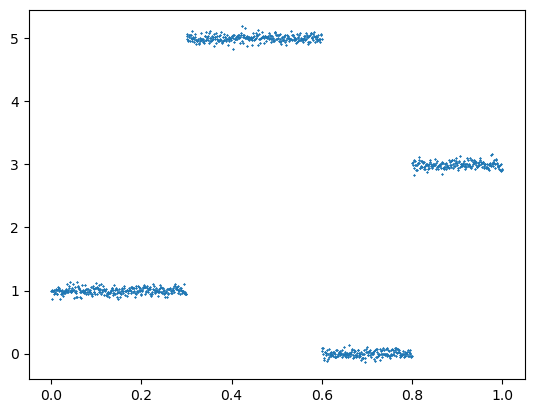

In [3]:
f = np.loadtxt('noisy_signal.csv')
axis = np.linspace(0, 1, num = len(f))




fig, plt_s = plt.subplots()
plt_s.plot(axis, f,'x', markersize = 1)

In [398]:
def obj_func(x,y,f, l, z, gradient = 'True' ):
    '''
    Penalized and smoothed least square simplified.

    Input: 
    x = a vector with the approximation of the signal.
    y = a sparse vector with the aproximation of the steps.
    f = a vector with noisy signals.
    l = a scalar, penalization parameter, how strict we want to be with the smoothness of the denoising
    z = regularization factor, to minimize discrepancies in each iteration.
    omega = penalization for the stepwise function steps.
    
    
    Output:
    x = value of the function.
    '''

    
    n = len(f)
    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]

 

    ##print( np.linalg.eig( np.transpose(Ahat) @ Ahat + np.transpose(Lhat) @ Lhat +max(gamma, 1 )) )

    
    ## estimate the value of the function #################################
    ## first term, signal estimator
    term1 = 0.5 *  ( (x -f).T @ (x -f)   )

    ## second term, similarity of xi with xi+1
    ## y allowance for steps.
    ## z regularization factor, sort of a restraint belt
    term2 = ( 0.5 * l ) * ( np.transpose(L@x -y + z) @ (L@x - y + z)   )


    res = term1 + term2 
    
    ## estimate the derivative of the function #################################

    if gradient:
        dterm1 = x - f
        dterm2 = -l * np.transpose(L) @ (y - L @ x - z)
        ##dterm2 = -(f + l * np.transpose(L) @ np.sign(L @ x - y + z))

    
        nabla = dterm1 + dterm2 
        
        return res, nabla  
    else:
        return res


def lipschitz_bound(n, gamma):
    ''' Estimate a sensible lipschitz bound for the hessian of the denoising function, with n elements.
    '''


    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]

    
    
    Ahat = np.c_[A, np.zeros((n,n) )]
    Lhat = np.c_[-L , A]

    ##print( np.linalg.eig( np.transpose(Ahat) @ Ahat + np.transpose(Lhat) @ Lhat +max(gamma, 1 )) )

    return np.linalg.norm( np.transpose(Ahat) @ Ahat + np.transpose(Lhat) @ Lhat ) ##+max(gamma, 1) )##, 'fro')




In [728]:
def variational_denoise_decoupled_gd(f, l, gamma, om, alpha, beta, plot = 'True'):
    '''
    Gradient descend to minimize the variational denoise function. This is a decoupled version
    with individual optimization of x and y.

    Input: 
    f = a vector with noisy signals.
    l = a scalar, penalization parameter, how strict we want to be with the smoothness of the denoising
    gamma = smoothing factor for approximation of norm-1
    omega = penalization for the stepwise function steps.
    
    
    Output:
    x = value of the function.

    '''

    ##  INITIALIZATION :problem initializes creating required variables and parameters ########################
    ###########################################################################################################
    ###########################################################################################################
    n = len(f)
    
    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]
    
    x = f.copy()
    y = L @ x
    z = np.ones(len(x), dtype = 'float')
    x.resize((len(x), 1))
    y.resize((len(y), 1))
    z.resize((len(z), 1))

    

    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]
    
    
    ##  FIRST ITERATION: required to assess the entry condition to descend loop ###############################
    ###########################################################################################################
    ###########################################################################################################


    ## DESCEND DIRECTION descend update for u
    fx, d = obj_func(x,y,f, l, z )
    dn = - d / np.linalg.norm(d)
    ## STEP SIZE first backtracking 
    
    s = .5
    b_i= 0
    xk = x + (s* beta**b_i ) * dn 
    fxk = obj_func(xk,y,f, l, z, False )
    
    
    while fxk > fx + alpha * (s* beta**b_i ) * np.dot(d.T,dn):
        b_i = b_i+1
        xk = x + (s* beta**b_i ) * dn 
        fxk = obj_func(xk,y,f, l, z,  False )
    print(b_i)
        

    
    t = L @ xk - z
    yk = np.zeros_like(y)
    
    axis = np.linspace(0, 1, num = len(f2))
    fig, plt_s = plt.subplots()
    plt_s.plot(axis[1:], f2[1:],'x', markersize = .5)
    plt_s.plot(axis[1:], xk[1:])

    fig, plt_s2 = plt.subplots()
    ##plt_s2.plot(axis, f2,'x', markersize = 1)
    plt_s2.plot(axis, y,'x', markersize = 3, label = "initial y")
    
    for i in range(0, len(y)):
        yk[i] =   (t[i] / np.abs(t[i]) ) * max(np.abs(t[i]) - (om/l), 0) ## y can be overwritten because I no longer need yk
        ##yk[i] = np.abs(t[i]) if np.abs(t[i]) > om/l else 0

    ##print("yk equals to ",yk)

    ##  END X first iter ######################################################################################
    ###########################################################################################################
    ###########################################################################################################

    ##  X loop ################################################################################################
    ###########################################################################################################
    ###########################################################################################################    
    
    
    iter = 0 
    print("entro al while con ", iter, np.linalg.norm(xk - x) / ( np.linalg.norm(xk)), np.linalg.norm(xk), np.linalg.norm(x) )
    while np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10)  > .00001 and iter < 10000: ##<--------------------------------------------iteración sobre x
        iter = iter + 1
        
        if iter % 10 == 0:
            plt_s.plot(axis[1:], xk[1:])
        
        
        z = +  (L @ xk - yk) ## y = yk, but an in place calc was done to avoid wasting space.
        x = xk
        y = yk
        
        ## DESCEND DIRECTION descend update for u
        fx, d = obj_func(x,y,f, l, z,  )
        dn = - d / np.linalg.norm(d)
    
        ## STEP SIZE first backtracking 
    
        s = .5
        b_i= 0
        xk = x + (s* beta**b_i ) * dn 
        fxk = obj_func(xk,y,f, l, z,  False )

        while fxk > fx + alpha * (s* beta**b_i ) * np.dot(d.T,dn):
            b_i = b_i+1
            xk = x + (s* beta**b_i ) * dn 
            fxk = obj_func(xk,y,f, l, z,False )

        t = L @ xk - z
        yk = np.zeros_like(y)
        for i in range(0, len(y)):
            yk[i] =   (t[i] / np.abs(t[i]) ) * max(np.abs(t[i]) - (om/l), 0) ## y can be overwritten because I no longer need yk
            ##yk[i] = np.abs(t[i]) if np.abs(t[i]) > om/l else 0
            
    print(iter, np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10), np.linalg.norm(xk - f) )
    plt_s.plot(axis[1:], xk[1:])

    
    plt_s2.plot(axis, yk,'x', markersize = 2, label = "final y")
    plt_s2.legend(fontsize = 8, frameon = True)
    plt.savefig('dcoupled_y.png')
    return x, y

4
entro al while con  0 0.0012260835535605524 97.9133923225495 97.91453718810136
61 8.384022192852256e-06 7.052144657507501
2.1946632862091064


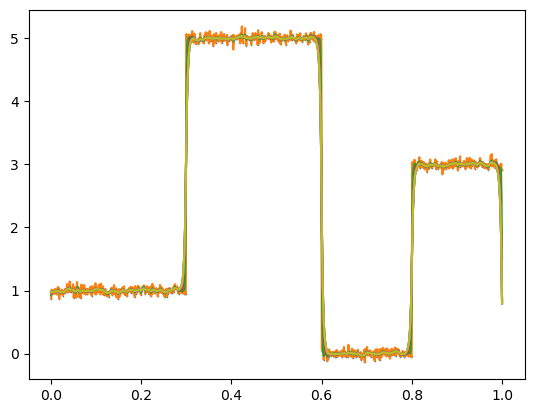

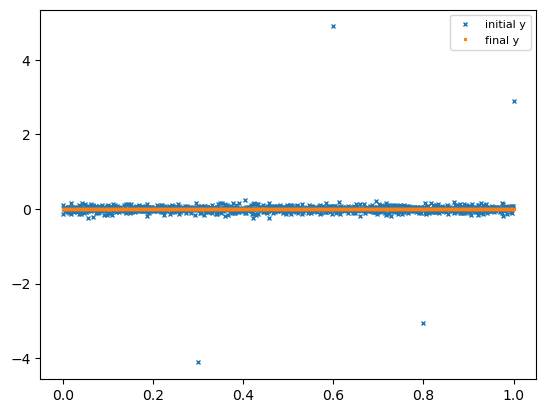

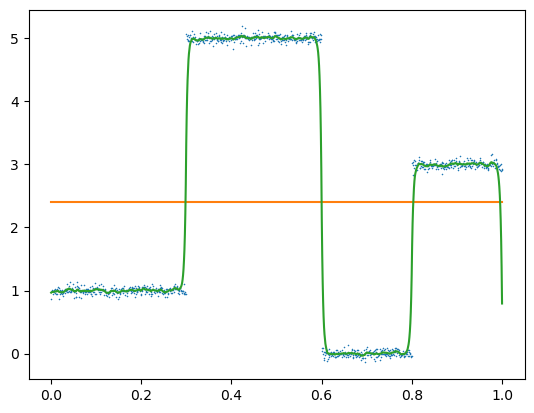

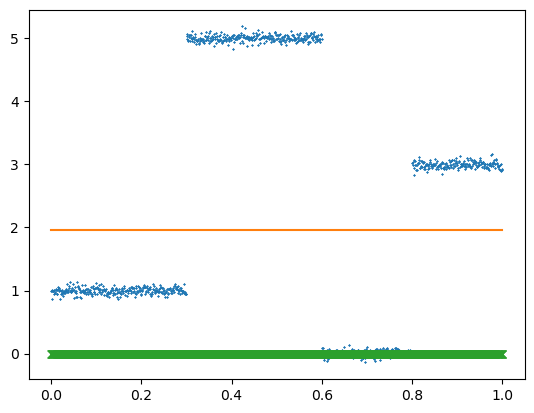

In [802]:
n = 500

f2 = f[0:n]

##f2 = np.array([1.02,.98,.99,1.012,1.001, 5.15,4.95,5.2,4.95,5.001, 0.01,-0.01,0.1,0.03,-.003,2.99,3.01,3.011, 2.992,3.1])

##f2 = f[0:n]

f2 = f.copy()

x = np.average(f2) * np.ones(len(f2) )
y = np.std(f2) * np.ones(len(f2))
l = 5
z = np.zeros(len(f2))
om = 10
alpha = .9
beta = .7



f2.resize((len(f2), 1))
z.resize((len(z), 1))
omega.resize((len(omega), 1))

start_time = time.time()
x2, y2 = variational_denoise_decoupled_gd(f2, l, gamma, om, alpha, beta)
end_time = time.time()

print(end_time -start_time )


axis = np.linspace(0, 1, num = len(f2))
fig, plt_s = plt.subplots()
plt_s.plot(axis[1:], f2[1:],'x', markersize = .5)
plt_s.plot(axis[1:], x[1:])
plt_s.plot(axis[1:], x2[1:])


fig, plt_s2 = plt.subplots()
plt_s2.plot(axis, f2,'x', markersize = 1)
plt_s2.plot(axis, y)
plt_s2.plot(axis, y2,'x')


0.07202148226938748


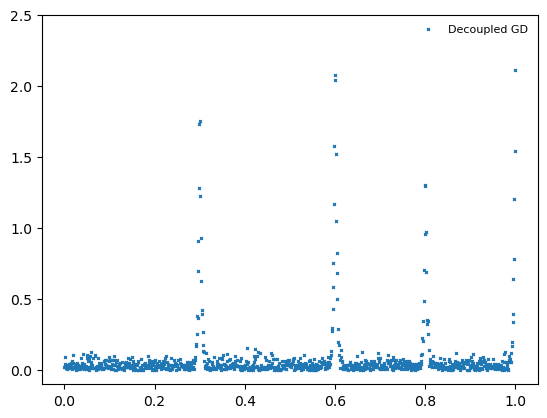

In [804]:
dif = []
for i in range(0, len(f)):
    dif.append(f[i]-x2[i])

print(np.linalg.norm(dif)/np.linalg.norm(f))

fig, plt_d2 = plt.subplots()
##plt_d2.plot(axis, f,'x', markersize = 1)
plt_d2.plot(axis,np.abs(dif), 'x', markersize = 2, label = 'Decoupled GD')
plt.ylim(-0.1, 2.5)
plt_d2.legend(fontsize = 8, frameon = False)
plt.savefig('dcoupled_error.png')

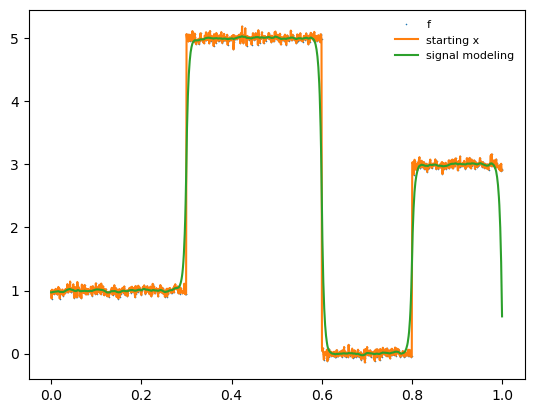

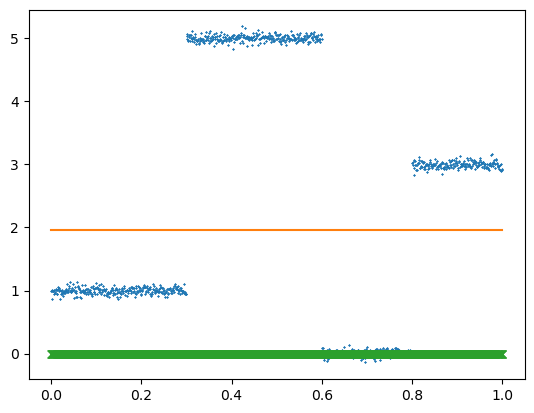

In [710]:
axis = np.linspace(0, 1, num = len(f2))
fig, plt_s = plt.subplots()
plt_s.plot(axis[0:], f2[0:],'x', markersize = .5, label = 'f')
plt_s.plot(axis[0:], f2[0:], label = 'starting x')
plt_s.plot(axis[0:], x2[0:], label = 'signal modeling')
plt_s.legend(fontsize = 8, frameon = False)
plt_s.legend(fontsize = 8, frameon = False)
plt.savefig('dcoupled_x.png')




fig, plt_s2 = plt.subplots()
plt_s2.plot(axis, f2,'x', markersize = 1)
plt_s2.plot(axis, y)
plt_s2.plot(axis, y2,'x')